In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier 
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score


/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('../csvs/short_integration_features.csv', index_col=0)
del df['instability_time']
del df['Rel_Eerr']
del df['Rel_Eerr_short']
del df["runstring"]
#Nrows = df.shape[0]
#print Nrows, len(np.where(df['Stable']==0)[0])
print df.shape
df.head()

(14999, 114)


,Stable,t_final_short,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
0,0.0,10000.0,1.000165,0.000329,1.001248,0.999691,0.000329,0.001083,0.000214,0.000456,...,4.706365,0.263380,5.264568,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,9041.175397
1,0.0,10000.0,0.999952,0.000739,1.002089,0.998309,0.000739,0.002137,0.000202,0.000463,...,1.777638,0.610370,2.507803,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,2192.382019
2,0.0,10000.0,0.998498,0.001948,1.002043,0.995446,0.001951,0.003550,0.001735,0.002860,...,0.982187,0.060058,1.060480,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,2191.525922
3,1.0,10000.0,1.000006,0.000026,1.000126,0.999973,0.000026,0.000120,0.000005,0.000009,...,9.848375,0.070031,9.914136,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,58599.215966
4,0.0,10000.0,1.067267,0.030186,1.121364,1.000000,0.028284,0.063028,0.004313,0.010716,...,1.453843,0.726529,2.660701,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,43524.152375


In [3]:
#"['daOverRH1' 'daOverRH2' 'mindaOverRH' 'maxdaOverRH' 'norm_LyapunovTime']"
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['Lyapunov_time']

y = df['Stable']
X = df[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,max_ecross2,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a1_slope,norm_a2_slope,norm_a3_slope,Lyapunov_time
0,0.396282,0.481704,0.000329,0.001083,0.000214,0.000456,0.000701,0.001978,0.000446,0.000964,...,0.333921,0.077775,0.297364,0.016641,0.339655,0.010871,-9.963524e-11,2.144832e-10,2.681898e-11,9041.175397
1,1.034575,0.823935,0.000739,0.002137,0.000202,0.000463,0.000200,0.000350,0.000226,0.000377,...,0.307149,0.075092,0.115674,0.039718,0.251880,0.137917,-4.938423e-11,3.559377e-11,-9.314702e-11,2192.382019
2,0.440470,0.491261,0.001951,0.003550,0.001735,0.002860,0.002303,0.004034,0.002080,0.003409,...,0.583040,0.328325,0.038930,0.002380,0.026117,0.007227,6.451005e-11,-3.330088e-11,-4.095504e-11,2191.525922
3,0.432098,0.550624,0.000026,0.000120,0.000005,0.000009,0.000019,0.000050,0.000016,0.000041,...,0.048402,0.000124,0.514386,0.003658,0.301072,0.279903,8.676076e-12,7.816527e-13,-7.257099e-12,58599.215966
4,5.722053,17.442426,0.028284,0.063028,0.004313,0.010716,0.038832,0.160685,0.090892,0.112168,...,9.321252,0.823132,0.496372,0.248052,1.358604,0.261358,6.816926e-08,3.913858e-08,-2.610208e-08,43524.152375


In [4]:
Nrows = int(X.shape[0] * 0.5)
trainX = X.iloc[:Nrows,:]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]

Don't worry about number of estimators, learning rate, or colsample_by_tree for now, come back to it afterwards

In [199]:
space ={
        'max_depth': hp.randint('x_max_depth',  10),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1)
}

In [200]:
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'])
    #initial method of using cv
    #eval_set  = [( testX, testY)]
    #clf.fit(trainX, trainY,
    #        eval_set=eval_set, eval_metric="auc", 
    #        early_stopping_rounds=10)
    #pred = clf.predict_proba(testX)[:,1]
    #auc = roc_auc_score(testY, pred)
    score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score = score.mean()
    print "SCORE:", score.mean()

    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score  }

In [201]:
trials = Trials()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials)

SCORE: 0.965517873892
SCORE: 0.965602290662
SCORE: 0.965462222454
SCORE: 0.965335250703
SCORE: 0.964487622318
SCORE: 0.965206576792
SCORE: 0.958454504579
SCORE: 0.96609685274
SCORE: 0.697026284189
SCORE: 0.965801555015


In [202]:
#print parameters that give the best values
print best

{'x_min_child': 6.0, 'x_max_depth': 8, 'x_subsample': 0.9205722376589776}


In [205]:
#try testing on the holdout set with these parameters
test_best = XGBClassifier(seed = 0, min_child_weight=best["x_min_child"],
                         max_depth = best["x_max_depth"],
                         subsample = best["x_subsample"])
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score

0.976727850408


In [206]:
#trying optimizing the next two parameters
space2 ={
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
        'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1),
}

In [207]:
def objective2(space2):

    clf = XGBClassifier(n_estimators = 100, 
                            min_child_weight=best["x_min_child"],
                            max_depth = best["x_max_depth"],
                            subsample = best["x_subsample"],
                            colsample_bytree =space2['colsample_bytree'],
                            learning_rate = space2['learning_rate'])

    score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score = score.mean()
    print "SCORE:", score.mean()
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score  }

In [208]:
trials2 = Trials()
best2 = fmin(fn=objective2, space = space2, algo = tpe.suggest, max_evals = 20, trials = trials2)

SCORE: 0.966191006574
SCORE: 0.965496735583
SCORE: 0.966666653122
SCORE: 0.965136182586
SCORE: 0.966183870946
SCORE: 0.964480188054
SCORE: 0.96510633213
SCORE: 0.961183954974
SCORE: 0.96628152536
SCORE: 0.966282417224
SCORE: 0.964769894643
SCORE: 0.96446306637
SCORE: 0.963748009246
SCORE: 0.966126045672
SCORE: 0.966334784875
SCORE: 0.96430597207
SCORE: 0.966211649697
SCORE: 0.96549139652
SCORE: 0.965240885808
SCORE: 0.965830186084


In [209]:
#With both optimizations, we can now see the all the selected parameters we are interested in
print best
print best2

{'x_min_child': 6.0, 'x_max_depth': 8, 'x_subsample': 0.9205722376589776}
{'x_tree_colsample': 0.9766575927226975, 'x_learning_rate': 0.05630431364712837}


In [212]:
#try testing on the holdout set with ALL of the selected parameters
test_best = XGBClassifier(seed = 0, min_child_weight=best["x_min_child"],
                         max_depth = best["x_max_depth"],
                         subsample = best["x_subsample"],
                         colsample_bytree = best2["x_tree_colsample"],
                         learning_rate = best2["x_learning_rate"])
#print trainX.shape, trainY.shape, testX.shape, testY.shape
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score
#score only increases marginally from before

0.976818242266


In [213]:
test_best.feature_importances_

array([ 0.02237569,  0.0140884 ,  0.01823204,  0.02292818,  0.0140884 ,
        0.01243094,  0.0461326 ,  0.04696133,  0.01933702,  0.01436464,
        0.01961326,  0.01381215,  0.01740332,  0.01187845,  0.04558011,
        0.0198895 ,  0.06657459,  0.03176796,  0.05911602,  0.03950276,
        0.08646408,  0.0301105 ,  0.04751381,  0.02265193,  0.06767956,
        0.02569061,  0.0281768 ,  0.03729282,  0.0301105 ,  0.06823204], dtype=float32)

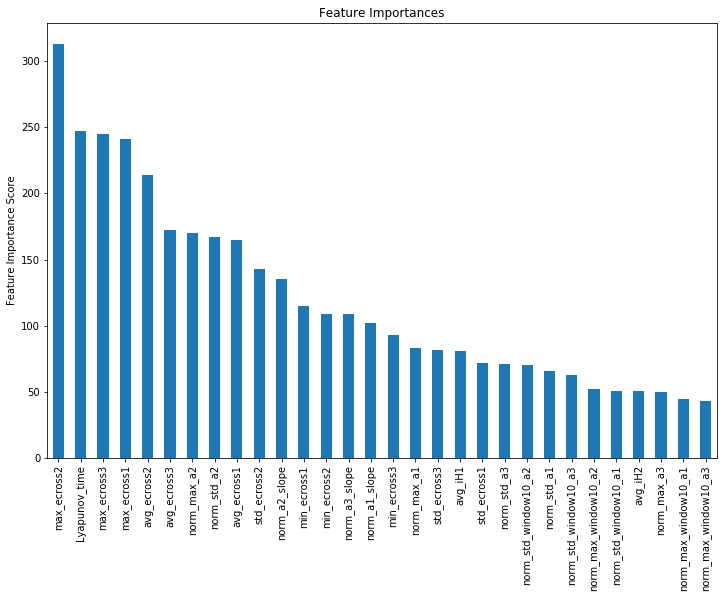

In [215]:
# feature importances
feat_imp = pd.Series(test_best.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()


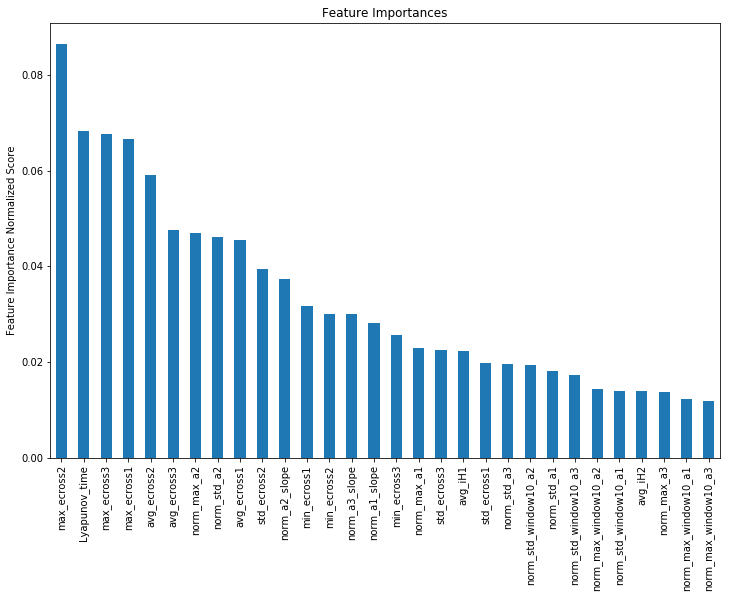

In [216]:
#try drawing a normalized version of the plot
feat_imp_norm = pd.Series(test_best.booster().get_fscore()).sort_values(ascending=False)
feat_imp_norm = feat_imp_norm/np.sum(feat_imp_norm)
#print feat_imp_norm
feat_imp_norm.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Normalized Score')
plt.show()

Try running the parameters together, and see if they change due to partial dependencies between any of them. Also increase number of iterations to ensure it has reached the optimal parameter space

In [5]:
space3 ={
        'max_depth': hp.quniform('x_max_depth', 1, 10,1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
        'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1)
}

In [220]:
def objective3(space3):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space3['max_depth'], 
                            min_child_weight =space3['min_child_weight'],
                            subsample = space3['subsample'],
                            colsample_bytree =space3['colsample_bytree'],
                            learning_rate = space3['learning_rate'])

    score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score = score.mean()
    print "SCORE:", score.mean()

    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score  }

In [221]:
trials3 = Trials()
import time
start = time.time()
best3 = fmin(fn=objective3, space = space3, algo = tpe.suggest, max_evals = 20, trials = trials3)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE: 0.965821173051
SCORE: 0.962177380211
SCORE: 0.96013244117
SCORE: 0.966260754133
SCORE: 0.957763767447
SCORE: 0.96628126038
SCORE: 0.965775828571
SCORE: 0.961776336339
SCORE: 0.960834396182
SCORE: 0.965478879385
SCORE: 0.963330428138
SCORE: 0.962426304292
SCORE: 0.966284505667
SCORE: 0.936319023971
SCORE: 0.966019042442
SCORE: 0.955467452278
SCORE: 0.965373778168
SCORE: 0.965432516807
SCORE: 0.962745015726
SCORE: 0.965158233263
('Optimization Time: %f seconds', 1700.054902791977)


In [223]:
scores = [val["result"]['cv_score'] for val in trials3]
losses = [val["result"]['loss'] for val in trials3]

In [224]:
print np.mean(scores), np.std(scores)

0.962042925881 0.00660538789678


In [228]:
print best3

{'x_min_child': 4.0, 'x_tree_colsample': 0.58953601238089, 'x_max_depth': 7.0, 'x_subsample': 0.9656894973700625, 'x_learning_rate': 0.07078850869231385}


In [257]:
#combine the two spaces
best_model2 = XGBClassifier(seed = 0, learning_rate=best3["x_learning_rate"],
                            min_child_weight=best3["x_min_child"],
                            max_depth= int(best3["x_max_depth"]), 
                            subsample = best3["x_subsample"],
                            colsample_bytree = best3["x_tree_colsample"])

best_model2.fit(trainX, trainY)
pred = best_model2.predict_proba(testX)[:,1]
score = roc_auc_score(testY, pred)
print score

0.977047306832


In [264]:
from xgboost import DMatrix

xgb_param = best_model2.get_xgb_params()
xgtrain = DMatrix(X.values, label=df['Stable'].values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=20, nfold=5, metrics='auc', early_stopping_rounds=10)

In [323]:
print type(cvresult)
print cvresult.shape
print cvresult.iloc[-1]["test-auc-mean"]
print  cvresult.iloc[-1]

<class 'pandas.core.frame.DataFrame'>
(20, 4)
0.974803
test-auc-mean     0.974803
test-auc-std      0.001876
train-auc-mean    0.988308
train-auc-std     0.000149
Name: 19, dtype: float64


In [7]:
from xgboost import DMatrix

#implemented with xgb cv
xgtrain = DMatrix(X.values, label=df['Stable'].values)

def objective4(space3):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space3['max_depth'], 
                            min_child_weight =space3['min_child_weight'],
                            subsample = space3['subsample'],
                            colsample_bytree =space3['colsample_bytree'],
                            learning_rate = space3['learning_rate'])
    start = time.time()
    cv_result = xgb.cv(clf.get_xgb_params(),xgtrain, num_boost_round=10, nfold=5, metrics='auc', early_stopping_rounds=5 )
    end = time.time()
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    score =  cv_result.iloc[-1]["test-auc-mean"]
    score_std =  cv_result.iloc[-1]["test-auc-std"]
    print ("SCORE %f, in : %f s:" % (score, (end-start)))

    return{'loss':1-score, 'status': STATUS_OK, "cv_score":score, "test_avg": score_std }

In [332]:
trials4= Trials()
import time
start = time.time()
best4 = fmin(fn=objective4, space = space3, algo = tpe.suggest, max_evals = 20, trials = trials4)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE %f, in : %f s: (0.96810759999999996, 90.31143617630005)
SCORE %f, in : %f s: (0.96624160000000003, 49.9987998008728)
SCORE %f, in : %f s: (0.94791659999999989, 32.73367691040039)
SCORE %f, in : %f s: (0.97172119999999995, 102.43022513389587)
SCORE %f, in : %f s: (0.94604719999999998, 43.02915382385254)
SCORE %f, in : %f s: (0.94892480000000001, 46.01954698562622)
SCORE %f, in : %f s: (0.9722016, 150.62837290763855)
SCORE %f, in : %f s: (0.97191819999999995, 158.68804907798767)
SCORE %f, in : %f s: (0.97223939999999998, 96.7362151145935)
SCORE %f, in : %f s: (0.95743359999999988, 38.94356393814087)
SCORE %f, in : %f s: (0.96024080000000001, 54.78683590888977)
SCORE %f, in : %f s: (0.95342899999999986, 57.16151714324951)
SCORE %f, in : %f s: (0.95553679999999996, 56.36310601234436)
SCORE %f, in : %f s: (0.96796579999999999, 80.83302307128906)
SCORE %f, in : %f s: (0.96258819999999989, 44.407516956329346)
SCORE %f, in : %f s: (0.96555780000000002, 26.518529176712036)
SCORE %f, in : 

In [333]:
print best4

{'x_min_child': 7.0, 'x_tree_colsample': 0.6514176031386798, 'x_max_depth': 9.0, 'x_subsample': 0.8961238654534123, 'x_learning_rate': 0.09755862056202982}


In [8]:
#implemented with xgb cv
# try now on a slightly smaller set of the data, and have a separate hold out set.
xgtrain = DMatrix(trainX.values, label=trainY.values)
trials5= Trials()
import time
start = time.time()
best5 = fmin(fn=objective4, space = space3, algo = tpe.suggest, max_evals = 20, trials = trials5)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE 0.943065, in : 0.680347 s:
SCORE 0.971156, in : 1.068611 s:
SCORE 0.960183, in : 0.788777 s:
SCORE 0.965015, in : 1.598737 s:
SCORE 0.948870, in : 0.466467 s:
SCORE 0.944642, in : 0.624894 s:
SCORE 0.971269, in : 1.021956 s:
SCORE 0.968989, in : 1.398300 s:
SCORE 0.948207, in : 0.522194 s:
SCORE 0.969835, in : 1.024922 s:
SCORE 0.966912, in : 1.605399 s:
SCORE 0.969156, in : 0.959453 s:
SCORE 0.962388, in : 0.942199 s:
SCORE 0.960445, in : 1.420642 s:
SCORE 0.970502, in : 1.035590 s:
SCORE 0.912762, in : 0.343881 s:
SCORE 0.969746, in : 1.428965 s:
SCORE 0.967728, in : 2.000438 s:
SCORE 0.967426, in : 1.000620 s:
SCORE 0.969794, in : 1.604430 s:
('Optimization Time: %f seconds', 21.89854598045349)


In [159]:
import hyperopt
hyperopt.__file__

'/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/hyperopt/__init__.pyc'

In [15]:
#try testing on the holdout set with ALL of the selected parameters
test_best = XGBClassifier(seed = 0, min_child_weight=best5["x_min_child"],
                         max_depth = int(best5["x_max_depth"]),
                         subsample = best5["x_subsample"],
                         colsample_bytree = best5["x_tree_colsample"],
                         learning_rate = best5["x_learning_rate"])
#print trainX.shape, trainY.shape, testX.shape, testY.shape
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score
print metrics.average_precision_score(testY, preds)
#score only increases marginally from before

0.977388357692
0.965115859285


Ignore all cells below

AUC Score (Test): 0.965116


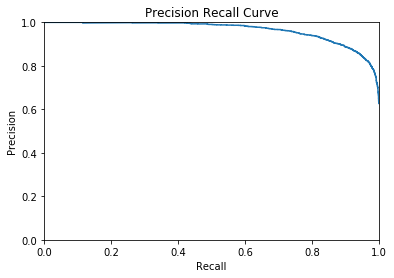

In [16]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print "AUC Score (Test): %f" % metrics.average_precision_score(testY, preds)
plt.show()


The result is still very good, so then these parameters generate a model that generalizes fairly well

In [342]:
#Try again with 40 trials, to see if there is an improvement
import time
start = time.time()
best5_more = fmin(fn=objective4, space = space3, algo = tpe.suggest, max_evals = 40, trials = trials5)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE 0.966605, in : 10.950023 s:
SCORE 0.971638, in : 21.362376 s:
SCORE 0.971486, in : 21.143568 s:
SCORE 0.969013, in : 13.201152 s:
SCORE 0.971001, in : 20.184471 s:
SCORE 0.970713, in : 20.187382 s:
SCORE 0.967807, in : 23.148881 s:
SCORE 0.970733, in : 33.916977 s:
SCORE 0.971024, in : 40.373488 s:
SCORE 0.971082, in : 50.323619 s:
SCORE 0.967850, in : 15.972994 s:
SCORE 0.971105, in : 27.917770 s:
SCORE 0.970609, in : 18.797427 s:
SCORE 0.971776, in : 26.747977 s:
SCORE 0.971542, in : 26.796972 s:
SCORE 0.914274, in : 6.401008 s:
SCORE 0.969348, in : 26.813246 s:
SCORE 0.970613, in : 21.555802 s:
SCORE 0.950217, in : 6.693871 s:
SCORE 0.970160, in : 16.343722 s:
('Optimization Time: %f seconds', 449.968092918396)


In [343]:
#try testing on the holdout set with ALL of the selected parameters
test_best = XGBClassifier(seed = 0, min_child_weight=best5_more["x_min_child"],
                         max_depth = int(best5_more["x_max_depth"]),
                         subsample = best5_more["x_subsample"],
                         colsample_bytree = best5_more["x_tree_colsample"],
                         learning_rate = best5_more["x_learning_rate"])
#print trainX.shape, trainY.shape, testX.shape, testY.shape
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score
#cv score on holdout set does not increase as you move from 20 trials to 40
#this means there is no need to run many trials, a small amount will be fine.

0.976681353609
